<a href="https://colab.research.google.com/github/Stephania-F/SummerSchool/blob/main/NFDI_Summerschool_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Classification of Image Data (Ising Modell)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# to use image data, we use fastai.vision
from fastai.vision.all import *
# At the latest, we should definitely use the GPU for computing. Therefore, the very first thing we test is,
# whether we have a valid CUDA device available.
print( torch.cuda.get_device_name(0) )
print( torch.__version__ )

Tesla V100-SXM2-16GB
2.0.1+cu118


In [ ]:
# fix random seed fixieren -> pseudo randomness
torch.manual_seed(0) # für pyTorch
random.seed(0)       # für python

## Download Data from Google Drive

In [ ]:
import os

file_id = '1CEQ264CdTSPAhG18ISb3IL4CT6sV2sQ0'
tmp_filename = 'bam_bruchflächen.zip'
training_data_path = 'data'

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

if not os.path.isfile(tmp_filename):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  gdrive = GoogleDrive(gauth)
  download = gdrive.CreateFile({'id': file_id})
  download.GetContentFile( tmp_filename )

# Extract File

In [ ]:
import zipfile
with zipfile.ZipFile(tmp_filename, 'r') as zip_ref:
    zip_ref.extractall( training_data_path )

## Load data

In [ ]:
# First we create the paths to the data
# Classification with eight classes
path = Path( training_data_path )

path

Path('data')

In [ ]:
print( "Subdirectories: ", path.ls() )
image_files = get_image_files(path/"0") + get_image_files(path/"1")
image_files

# now we define a function that generates the label for each file name. In our case we can
# you can see it on the subdirectory. For the label function you always have to look at the directory structure # and how the filenames are built.
# and how the filenames are built.
def label_function(filename):
    return filename.parents[0].name

Subdirectories:  [Path('data/Interkristallin'), Path('data/Schwingbruch')]


When loading, we can specify transformations to change images (e.g. resize them) and implement data augmentations. In our case, the images are already the right size (64x64 pixels), but we use some data augmentations to improve generalization. We also normalize the data to ImageNet's statistics.

In [ ]:
item_transforms  = []

# If images are to be resized, this can be done as follows:
# item_transforms  = [Resize(224, method='crop')]

batch_transforms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]

We create a RandomSplitter to divide the data into training and validation data.

In [ ]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

Now we create a DataBlock. Here we first specify which "blocks", i.e. encoding types are to be used. In our case we need ImageBlock for the input and CategoryBlock for the output.

In [ ]:
blocks = (ImageBlock, CategoryBlock)

block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=label_function,
                  splitter=splitter,
                  item_tfms=item_transforms,
                  batch_tfms=batch_transforms)

In [ ]:
batchSize = 4
data_loader = block.dataloaders(path, bs=batchSize, num_workers=0)

To see the effect of these transformations, you can run the following cell as many times as you like. New transformed images will always be created. By changing the index, you choose a different initial image for the transformation.

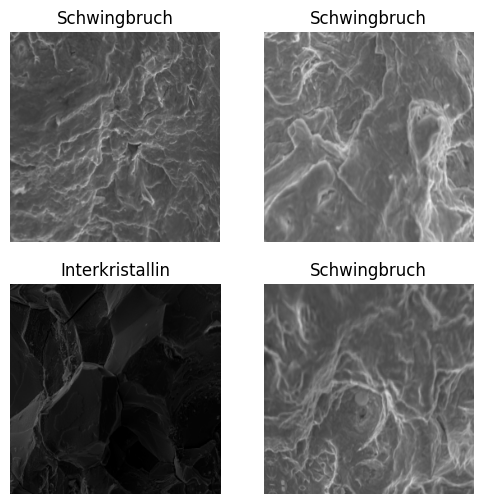

In [ ]:
data_loader.show_batch()

## Training: Resnet34

Now we know what our data looks like and we're satisfied that the data and class loading, as well as the transformations, are working as they should. So it's time to train an initial model with the data. You can test different architectures or models and metrics.

In [ ]:
architektur = resnet34
metrik = error_rate

Other architectures you can test are:
* alexnet
* vgg16_bn
* densenet121 (161, 169, 201)
* resnet18 (34, 50, 101, 152)

Even more architectures are offered by "torchvision". You can import them as follows:

In [ ]:
import torchvision.models as torchModels

Other metrics you can test are:
* accuracy
* error_rate
* dice

There are other metrics, but they cannot be used in this example:
* mean_squared_error
* mean_absolute_error
* mean_squared_logarithmic_error
* exp_rmspe
* explained_variance
* r2_score

In [ ]:
learner = cnn_learner(data_loader,
                      architektur,
                      metrics = metrik)

learner.loss_func

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FlattenedLoss of CrossEntropyLoss()

We store the randomly initialized model for later experiments.

In [ ]:
learner.save("resnet34_initial")

Path('models/resnet34_initial.pth')

SuggestedLRs(valley=0.001737800776027143)

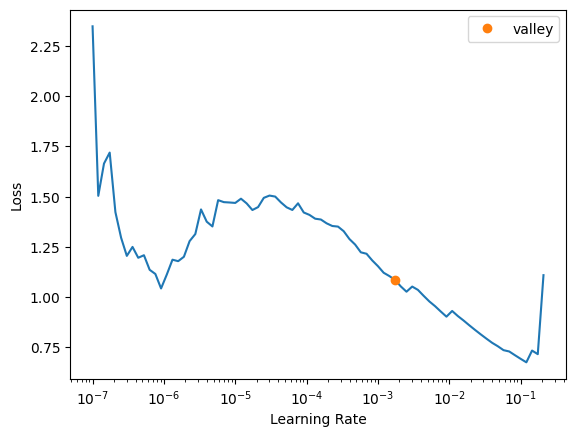

In [ ]:
learner.lr_find()

Based on the learner rate finder you can test different learning rates. Remember to recreate the learner beforehand so that you always start with a random initialization of the weights.

In [ ]:
gewaehlteLernrate = 1e-01
learner.load("resnet34_initial")
learner.fit_one_cycle( 5, lr_max=gewaehlteLernrate )

epoch,train_loss,valid_loss,error_rate,time
0,7.406063,2.438694,0.476289,02:02
1,6.889329,3.661123,0.423711,01:58
2,2.085467,0.828880,0.498969,01:55
3,0.723345,1.055267,0.478351,01:55
4,0.288244,0.147083,0.010309,01:56


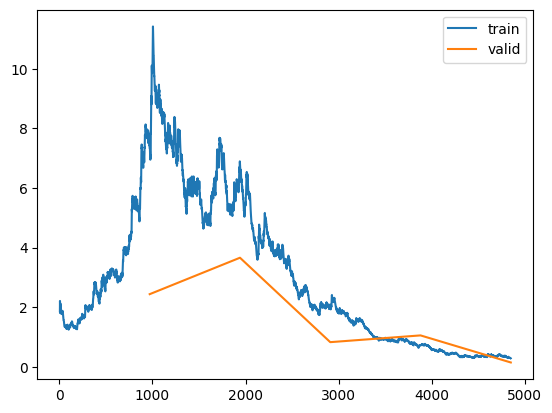

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save('resnet34_phase1')

Path('models/resnet34_phase1.pth')

## Results

We can now examine the learned models with respect to the accuracy of the classification. First, we look at which class is most often interchanged with which. In the case of many classes, this comparison is of course more meaningful. In our case with 2 classes, we can only see if the proportion of interchanges is about the same.

In [ ]:
interpretation = ClassificationInterpretation.from_learner(learner)

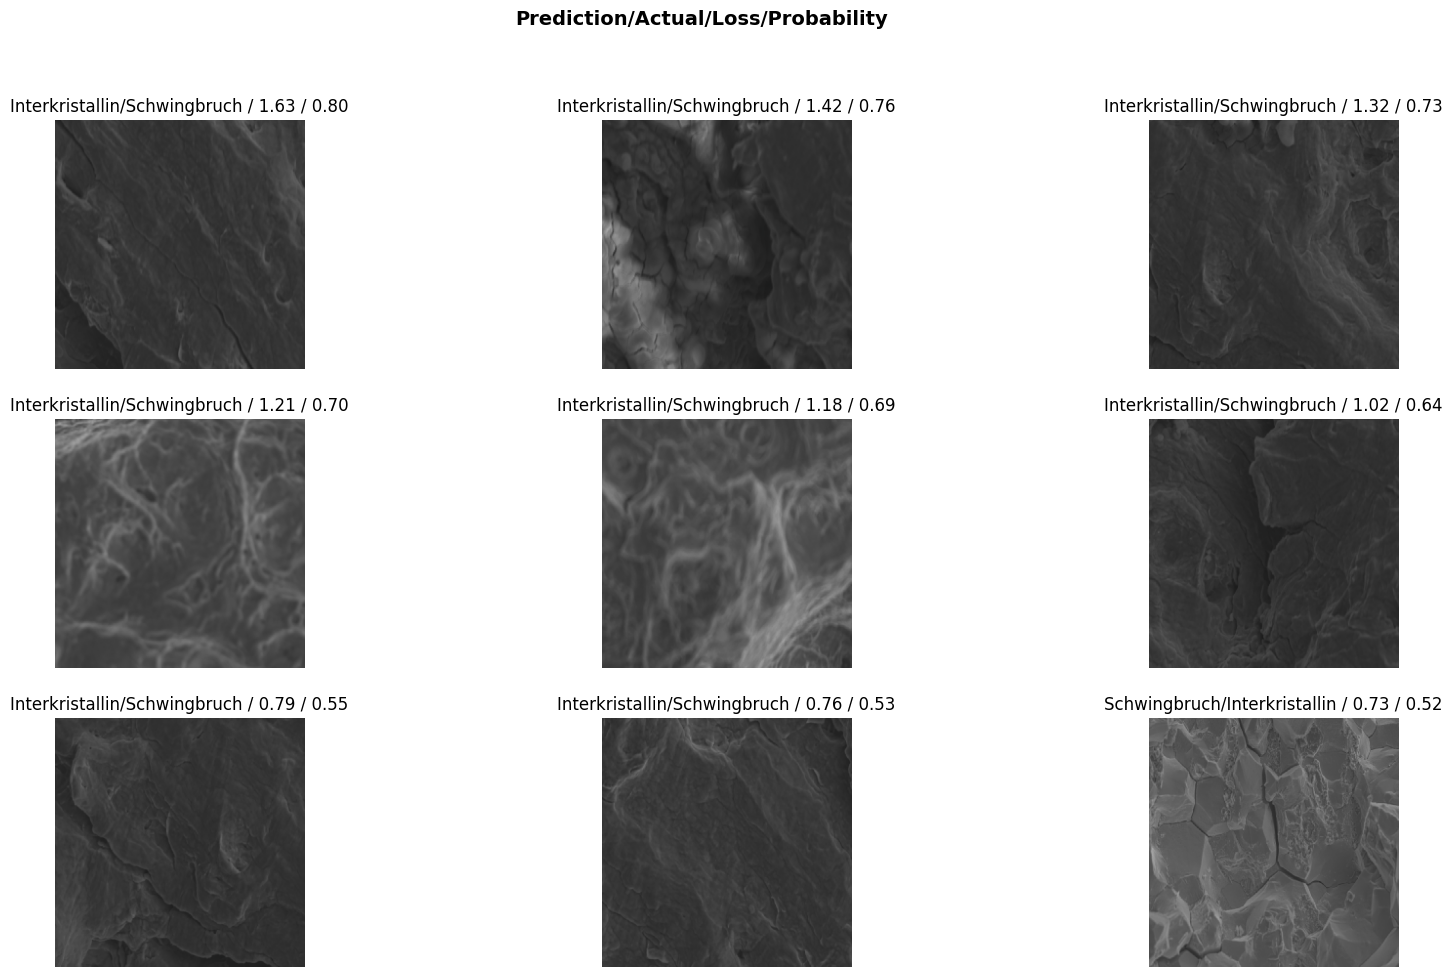

In [ ]:
interpretation.plot_top_losses(9, figsize=(20,11))

In [ ]:
interpretation.most_confused(min_val=1)

[('Schwingbruch', 'Interkristallin', 9),
 ('Interkristallin', 'Schwingbruch', 1)]

Mit Hilfe einer Confusion Matrix lässt sich dies in unserem einfachen Fall auch leicht sehen.

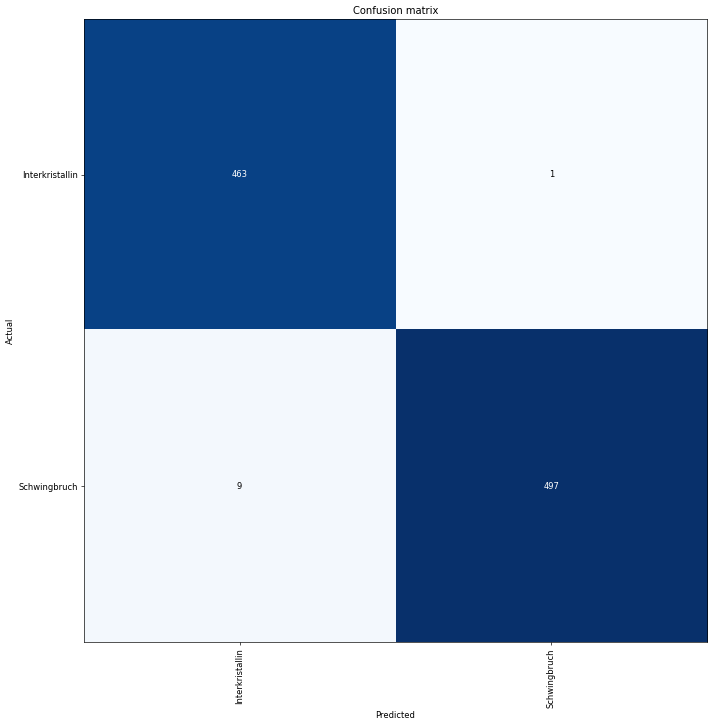

In [ ]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)